In [59]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import root_numpy as rtnp
import ROOT as rt
import ROOT.RooFit as rf
from array import array
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from gridVarQ2Plot import col_dic
from analysis_utilities import drawOnCMSCanvas
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_pi = 0.13957
m_K = 0.49368
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

# Load data

In [6]:
loc = '../data/cmsRD/'
loc += 'ParkingBPH*/'
loc += 'Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbe_Bp2DmstPipPip_200415_CAND.root'

tData = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tData.Add(floc)

print 'N evts: {:.0f}'.format(tData.GetEntries())

N evts: 1903236


In [7]:
# loc = '../data/cmsMC_private/'
# loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
# loc += '/ntuples_B2DstMu/out_CAND_*.root'

# tMu = rt.TChain('outA/Tevts')
# for floc in glob(loc):
#     tMu.Add(floc)

# print 'N evts: {:.0f}'.format(tMu.GetEntries())

In [8]:
def addOverflow(hh):
    Nbins = hh.GetNbinsX()
    hh.SetBinContent(Nbins, hh.GetBinContent(Nbins) + hh.GetBinContent(Nbins+1))
    hh.SetBinContent(Nbins+1, 0)
    return

In [9]:
def appendNewHisto(var, h_list, cuts, addCuts, leg=None, overflow=True):
    lastName = h_list[-1].GetName()
    if lastName == 'h':
        N =1
    else:
        N = 1 + int(lastName[1:])
        
    hAux = create_TH1D(np.zeros(0), name='h'+str(N), binning=h_list[0].binning)
    tData.Project('h'+str(N), var, cuts + ' && ' + addCuts)
    hAux.SetLineColor(col_dic.values()[N-1])
    hAux.Sumw2()
    if overflow:
        addOverflow(hAux)
    hAux.SetLineWidth(2)
    h_list.append(hAux)
    
    if not leg is None:
        leg.AddEntry(hAux, addCuts, 'lep')
    
    return h_list

# Cuts declaration

In [10]:
cut_general = [
    'n_B == 1',
#     'trgMu_pt > 12.1',
#     'trgMu_sigdxy > 7',
#     'abs(trgMu_eta) < 1.5',
]

$D_0$ reconstruction

In [11]:
cut_piK = [
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'abs(K_eta) < 2.4',
'abs(pi_eta) < 2.4',
'abs(mass_piK - 1.864) < 0.05',
]

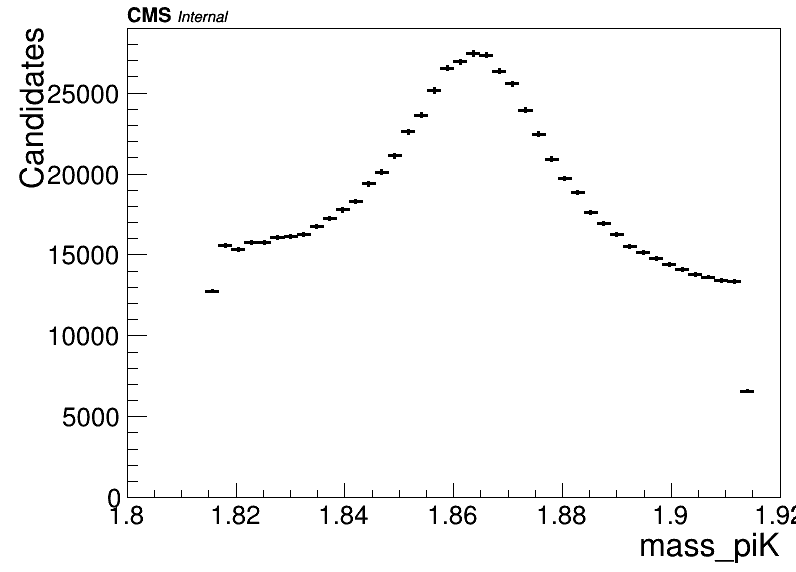

In [12]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
addOverflow(h)
# h.Scale(1./h.Integral())
h.SetLineWidth(3)
h_list=[h]

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')

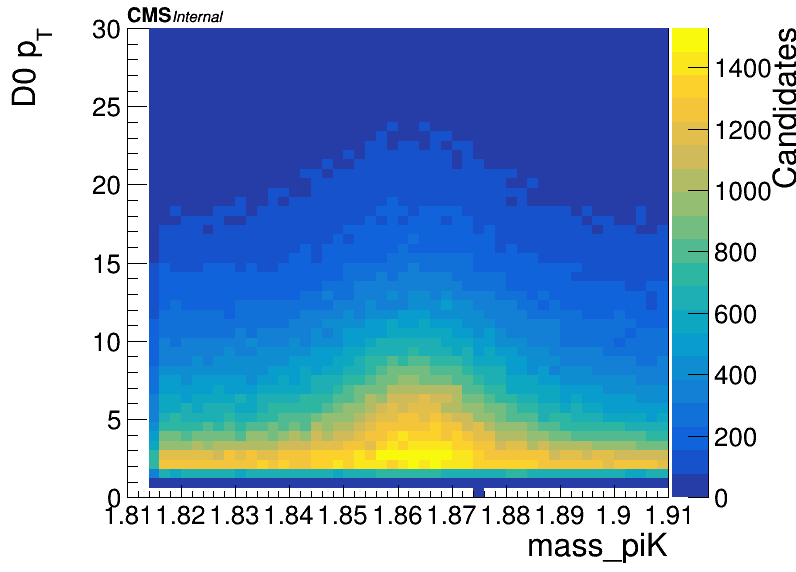

In [13]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass_piK', 'D0 p_{T}', 'Candidates'],
                binning=[50, 1.81, 1.91, 50, 0., 30.] )
tData.Project('h', 'D0_pt:mass_piK', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

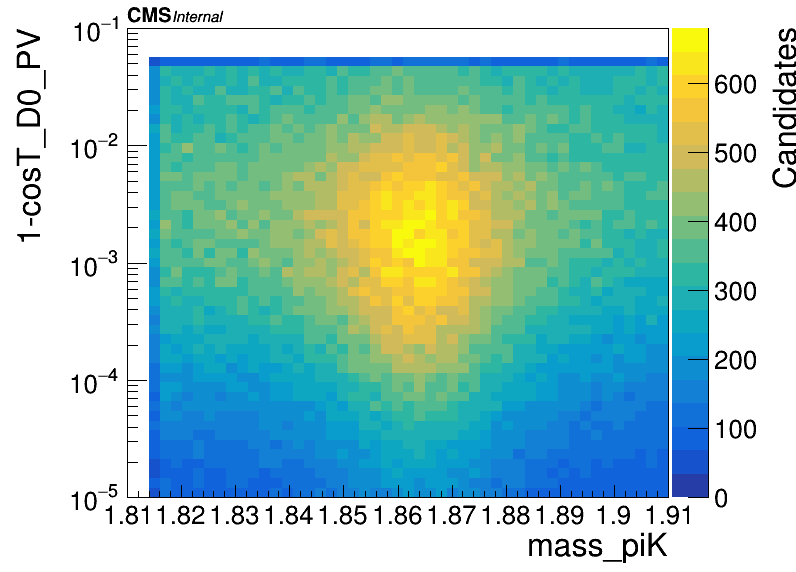

In [14]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass_piK', '1-cosT_D0_PV', 'Candidates'],
                binning=[np.linspace(1.81, 1.91, 50), np.logspace(-5, -1, 50)] )
tData.Project('h', '1 - cosT_D0_PV:mass_piK', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

<ROOT.TLine object ("TLine") at 0xe474da0>

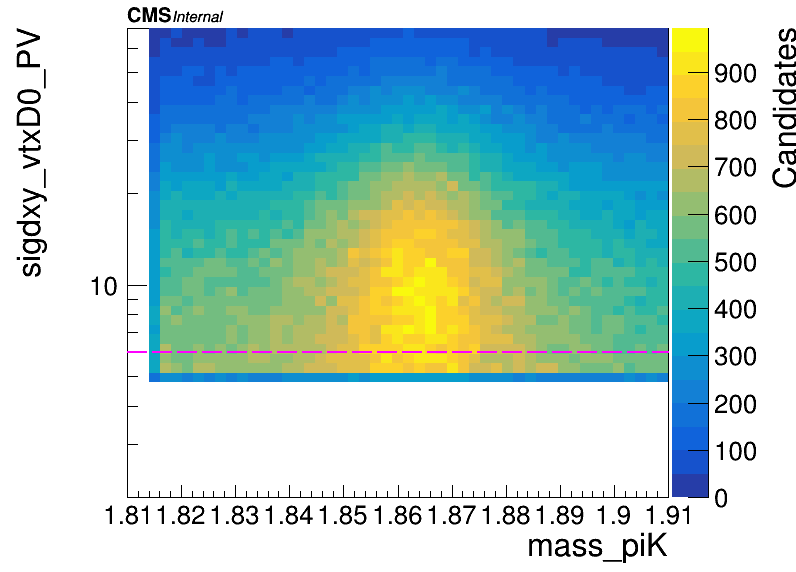

In [15]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass_piK', 'sigdxy_vtxD0_PV', 'Candidates'],
                binning=[np.linspace(1.81, 1.91, 50), np.logspace(np.log10(2), np.log10(70), 50)] )
tData.Project('h', 'sigdxy_vtxD0_PV:mass_piK', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()
cl.DrawLine(1.81, 6, 1.91, 6)

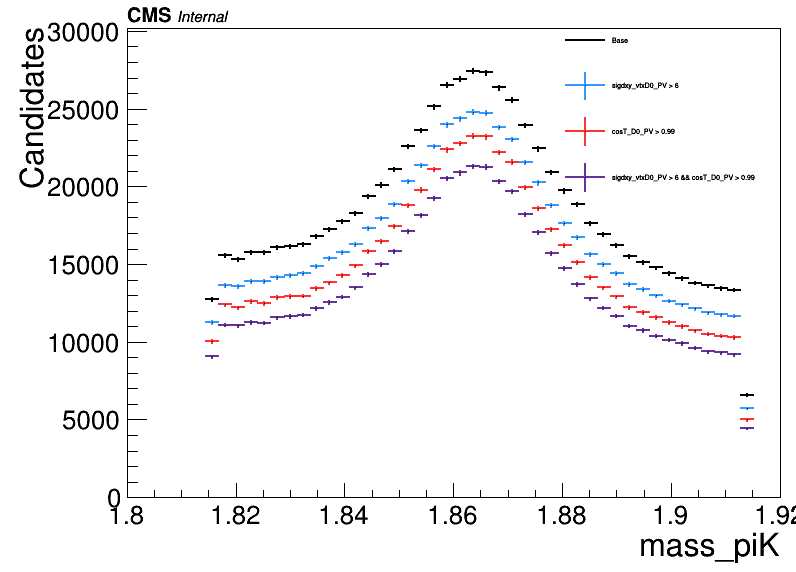

In [16]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
addOverflow(h)
h.SetLineWidth(2)
h_list=[h]

leg = rt.TLegend(0.7, 0.65, 0.98, 0.97)
leg.AddEntry(h, 'Base', 'l')
leg.SetTextFont(42)
leg.SetFillStyle(0)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

appendNewHisto('mass_piK', h_list, cuts, 'sigdxy_vtxD0_PV > 6', leg=leg)
appendNewHisto('mass_piK', h_list, cuts, 'cosT_D0_PV > 0.99', leg=leg)
appendNewHisto('mass_piK', h_list, cuts, 'sigdxy_vtxD0_PV > 6 && cosT_D0_PV > 0.99', leg=leg)

SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()

In [17]:
cut_piK_rev = [
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'abs(K_eta) < 2.4',
'abs(pi_eta) < 2.4',
'abs(mass_piK - {}) < 0.035'.format(m_D0),
'sigdxy_vtxD0_PV > 6',
'cosT_D0_PV > 0.99'
]

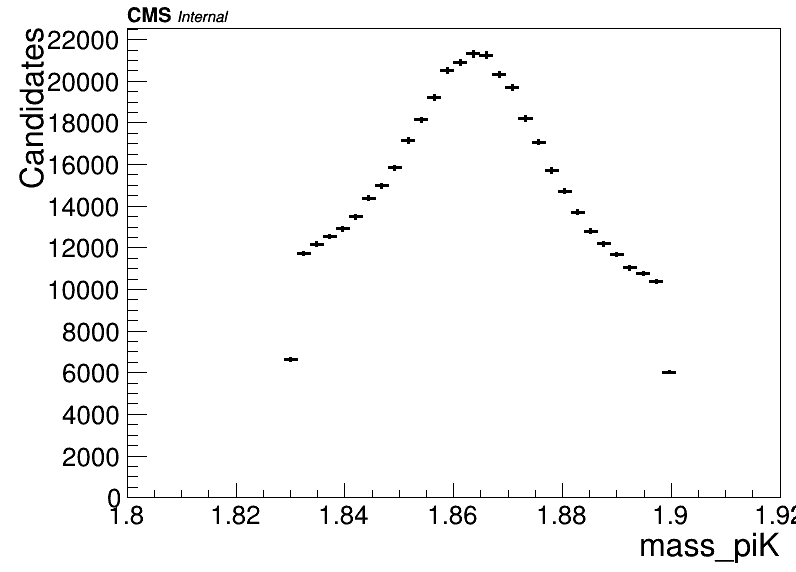

In [18]:
cuts = ' && '.join(cut_general+cut_piK_rev)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
h.SetLineWidth(3)
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

In [19]:
tData.GetEntries(' && '.join(cut_general+cut_piK))

777535L

# $D^*$ Recostruction

In [20]:
cut_D0pipi = [
'pi1_pt > 1.',
'abs(pi1_eta) < 2.4',
'pi2_pt > 1.',
'abs(pi2_eta) < 2.4',
'pval_D0pipi > 0.1',
]

In [21]:
tData.GetEntries(' && '.join(cut_general+cut_piK+cut_D0pipi))

213762L

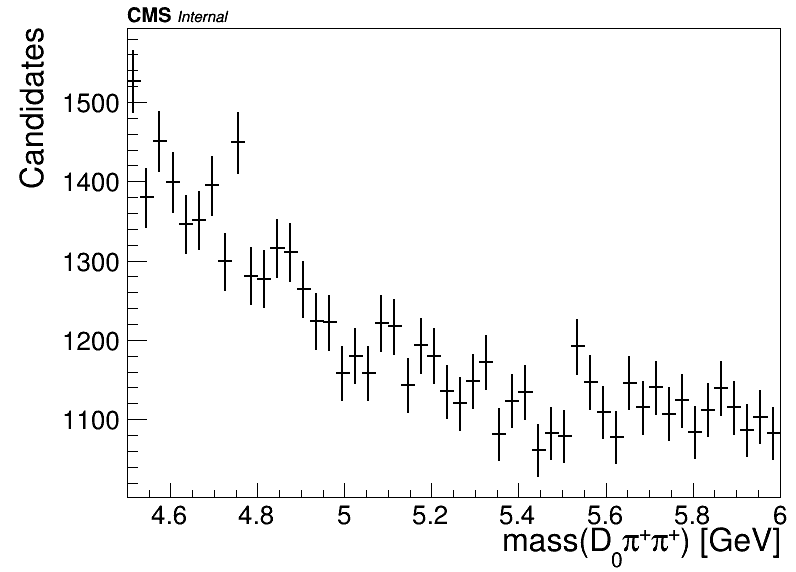

In [22]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipi)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}#pi^{+}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.5, 6] )
tData.Project('h', 'mass_D0pipi', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

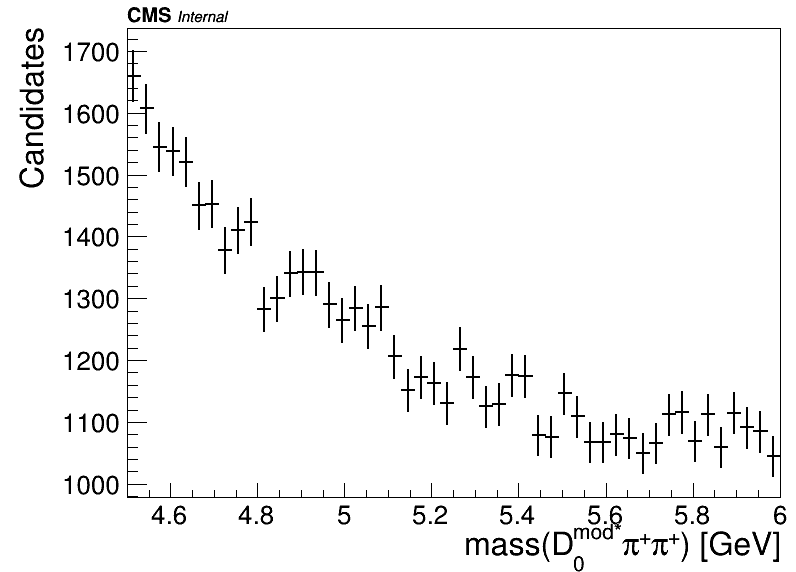

In [23]:
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{mod*}#pi^{+}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.5, 6] )
tData.Project('h', 'mass_D0pipi_scaledDst', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

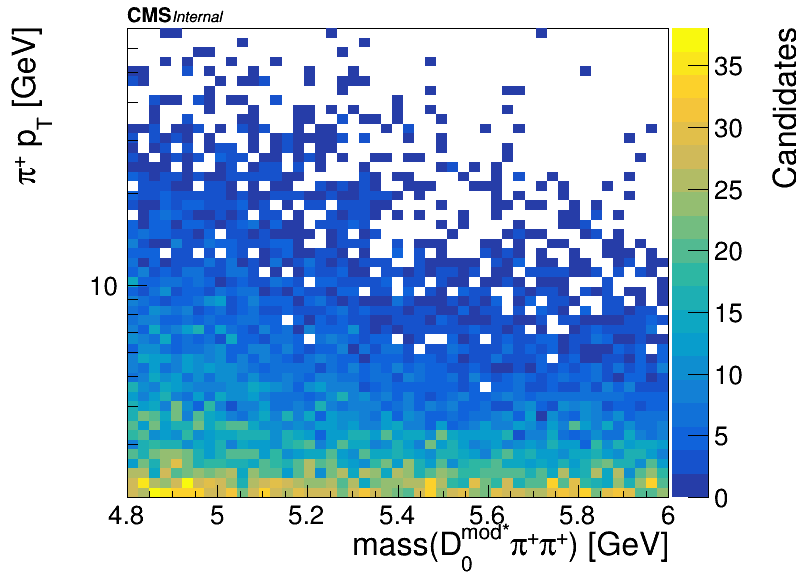

In [24]:
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{mod*}#pi^{+}#pi^{+}) [GeV]', '#pi^{+} p_{T} [GeV]', 'Candidates'],
                binning=[np.linspace(4.8, 6, 50), np.logspace(np.log10(2), np.log10(70), 50)] )
tData.Project('h', 'pi1_pt:mass_D0pipi_scaledDst', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

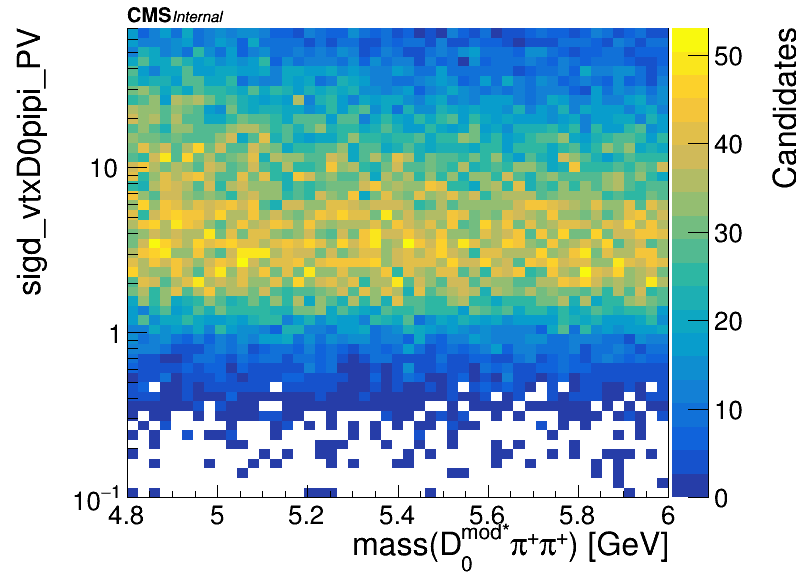

In [25]:
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{mod*}#pi^{+}#pi^{+}) [GeV]', 'sigd_vtxD0pipi_PV', 'Candidates'],
                binning=[np.linspace(4.8, 6, 50), np.logspace(-1, np.log10(70), 50)] )
tData.Project('h', 'sigd_vtxD0pipi_PV:mass_D0pipi_scaledDst', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

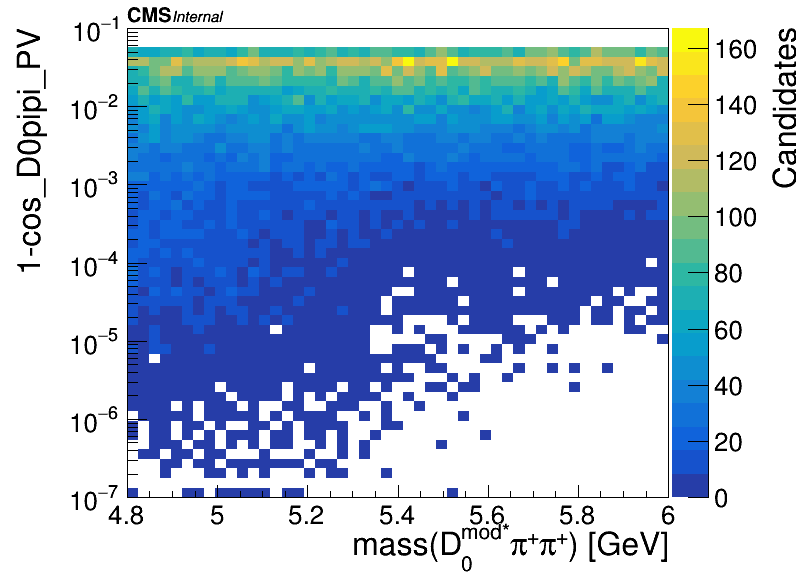

In [26]:
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{mod*}#pi^{+}#pi^{+}) [GeV]', '1-cos_D0pipi_PV', 'Candidates'],
                binning=[np.linspace(4.8, 6, 50), np.logspace(-7, -1, 50)] )
tData.Project('h', '1-cos_D0pipi_PV:mass_D0pipi_scaledDst', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

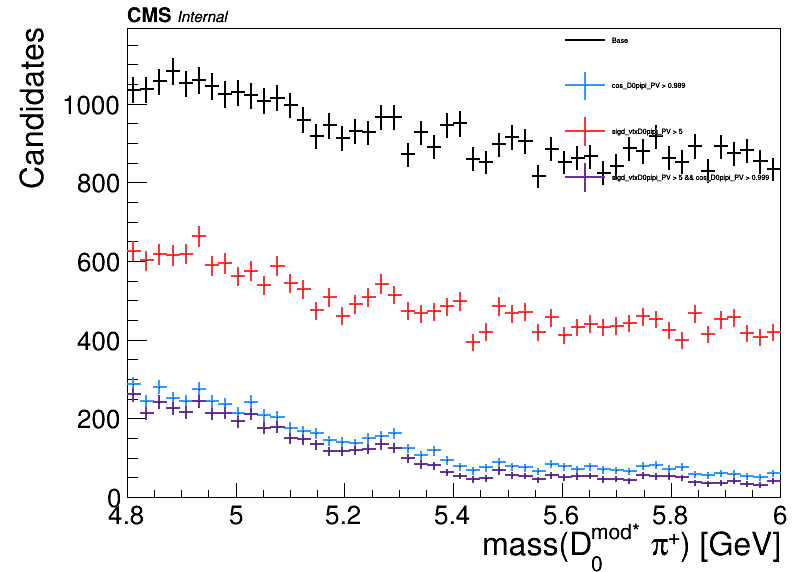

In [35]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipi)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{mod*} #pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.8, 6] )
tData.Project('h', 'mass_D0pipi_scaledDst', cuts)
h.Sumw2()
h.SetLineWidth(2)
h_list=[h]

leg = rt.TLegend(0.7, 0.65, 0.98, 0.97)
leg.AddEntry(h, 'Base', 'l')
leg.SetTextFont(42)
leg.SetFillStyle(0)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

appendNewHisto('mass_D0pipi_scaledDst', h_list, cuts, 'cos_D0pipi_PV > 0.999', leg=leg, overflow=False)
appendNewHisto('mass_D0pipi_scaledDst', h_list, cuts, 'sigd_vtxD0pipi_PV > 5', leg=leg, overflow=False)
appendNewHisto('mass_D0pipi_scaledDst', h_list, cuts, 'sigd_vtxD0pipi_PV > 5 && cos_D0pipi_PV > 0.999', leg=leg, overflow=False)
appendNewHisto('mass_D0pipi_scaledDst', h_list, cuts, 'sigd_vtxD0pipi_PV > 5 && cos_D0pipi_PV > 0.999', leg=leg, overflow=False)

m = SetMaxToMaxHist(h_list)
h_list[0].GetYaxis().SetRangeUser(0, m)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()

In [36]:
cut_D0pipi_rev = [
'pi1_pt > 1.',
'abs(pi1_eta) < 2.4',
'pi2_pt > 1.',
'abs(pi2_eta) < 2.4',
'pval_D0pipi > 0.1',
'cos_D0pipi_PV > 0.999',
'sigd_vtxD0pipi_PV > 5'
]

In [40]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipi_rev)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{mod*}#pi^{+}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.8, 5.8] )
tData.Project('h', 'mass_D0pipi_scaledDst', cuts)
h.Sumw2()

In [41]:
fBkg = rt.TF1('fBkg', 'pol3', 4.8, 5.8)
gBkg = rt.TGraphErrors()
for i in range(1,51):
    x = h.GetBinCenter(i)
    if x < 5.1 or x > 5.4:
        y = h.GetBinContent(i)
        gBkg.SetPoint(i-1, x, y)
        gBkg.SetPointError(i-1, 0, h.GetBinError(i))

gBkg.Fit(fBkg, 's')


****************************************
Minimizer is Linear
Chi2                      =       46.017
NDf                       =           31
p0                        =     -32605.9   +/-   13581.2     
p1                        =      20106.1   +/-   7625.66     
p2                        =     -4052.83   +/-   1424.62     
p3                        =       268.46   +/-   88.5624     


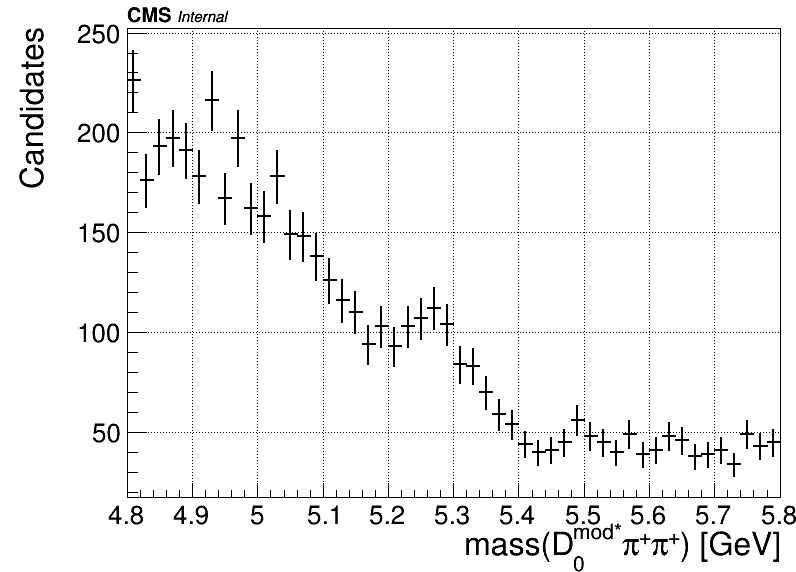

In [43]:
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetGrid()
# fBkg.Draw('same')

In [ ]:
raise

# Try to extract infos

In [44]:
def getTLVfromField(ev, n, idx, mass):
    v = rt.TLorentzVector()
    v.SetPtEtaPhiM(getattr(ev, n+'_pt')[idx], 
                   getattr(ev, n+'_eta')[idx], 
                   getattr(ev, n+'_phi')[idx], 
                   mass)
    return v

In [56]:
leafs_names = [
    'mass_pipi', 'mass_D0pi1', 'mass_D0pi2',
    'mass_D0pipi', 'mass_D0pipi_scaledDst', 'mass_D0pipi_scaledDstst',
    'cosThetaSt_pi1', 'cosThetaSt_pi2'
]
output = np.zeros((tData.GetEntries(), len(leafs_names)))
N_accepted_tot = 0
N_accepted_cand = []

pb = ProgressBar(maxEntry=tData.GetEntries())
for i_ev, ev in enumerate(tData):
        pb.show(i_ev)
        N_acc = 0

        ev_output = []
        for j in range(ev.pval_piK.size()):            
            if not ev.K_pt[j] > 0.8: continue
            if not ev.pi_pt[j] > 0.8: continue
            if not ev.pval_piK[j] > 0.1: continue
            if not np.abs(ev.K_eta[j]) < 2.4: continue
            if not np.abs(ev.pi_eta[j]) < 2.4: continue
            if not np.abs(ev.mass_piK[j] - 1.86483) < 0.035: continue
            if not ev.sigdxy_vtxD0_PV[j] > 6: continue
            if not ev.cosT_D0_PV[j] > 0.99: continue
            if not ev.pi1_pt[j] > 1.: continue
            if not np.abs(ev.pi1_eta[j]) < 2.4: continue
            if not ev.pi2_pt[j] > 1.: continue
            if not np.abs(ev.pi2_eta[j]) < 2.4: continue
            if not ev.pval_D0pipi[j] > 0.1: continue
            if not ev.cos_D0pipi_PV[j] > 0.999: continue
            if not ev.sigd_vtxD0pipi_PV[j] > 5: continue
            if ev.mass_D0pipi_scaledDst[j] < 4.8 or ev.mass_D0pipi_scaledDst[j] > 5.8: continue

            N_acc += 1
            
            p4_pi1 = getTLVfromField(ev, 'pi1', j, m_pi)
            p4_pi2 = getTLVfromField(ev, 'pi2', j, m_pi)
            
            p4_D0pipi = getTLVfromField(ev, 'D0pipi', j, ev.mass_D0pipi[j])
            p4_Bs = getTLVfromField(ev, 'D0pipi_sDst', j, ev.mass_D0pipi_scaledDst[j])
            
            p4_aux = p4_Bs - p4_D0pipi
            p4_D0 = rt.TLorentzVector()
            p4_D0.SetPtEtaPhiM(p4_aux.Pt()/(m_Dst/m_D0 - 1), p4_aux.Eta(), p4_aux.Phi(), ev.mass_piK[j])
            
            p4_pipi = p4_D0pipi - p4_D0
            
            p4_aux = rt.TLorentzVector()
            r = 2.5/m_D0
            p4_aux.SetPtEtaPhiM(r*p4_D0.Pt(), p4_D0.Eta(), p4_D0.Phi(), r*ev.mass_piK[j])
            p4_D0pipi_scDstst = p4_aux + p4_pipi
            
            p4st_pi1 = rt.TLorentzVector(p4_pi1)
            p4st_pi1.Boost(-1*p4_Bs.BoostVector())
            cosThetaSt_pi1 = np.cos(p4st_pi1.Angle(p4_Bs.BoostVector()))
            
            p4st_pi2 = rt.TLorentzVector(p4_pi2)
            p4st_pi2.Boost(-1*p4_Bs.BoostVector())
            cosThetaSt_pi2 = np.cos(p4st_pi2.Angle(p4_Bs.BoostVector()))
            
            aux = (p4_pipi.M(), (p4_D0+p4_pi1).M(), (p4_D0+p4_pi2).M(),
                   ev.mass_D0pipi[j], ev.mass_D0pipi_scaledDst[j], p4_D0pipi_scDstst.M(),
                   cosThetaSt_pi1, cosThetaSt_pi2
                  )
            ev_output.append(aux)
            
        N_acc = len(ev_output)
        idx = 0
        if N_acc > 1:
            idx = np.random.randint(len(ev_output))
        if N_acc > 0:
            output[N_accepted_tot] = ev_output[idx]
            N_accepted_tot += 1
            N_accepted_cand.append(N_acc)

output = output[:N_accepted_tot]

[####################]  100% - Tot. time: 448.2 s


NameError: name 'pd' is not defined

In [65]:
dset = pd.DataFrame(output, columns=leafs_names)
rtnp.array2root(dset.to_records(), 'tmp/TnP_B2DststPipi.root', treename='Tevts', mode='RECREATE')

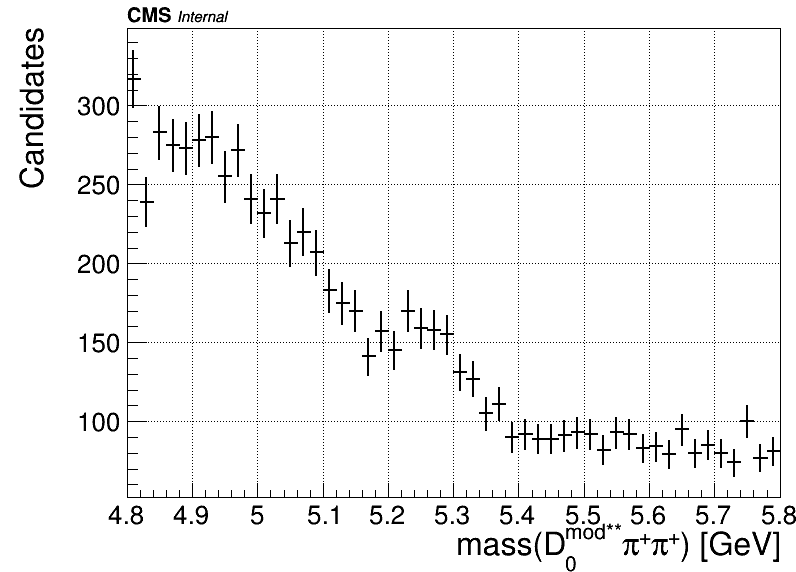

In [76]:
h = create_TH1D(dset['mass_D0pipi_scaledDst'], name='h',
                title='', axis_title=['mass(D_{0}^{mod**}#pi^{+}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.8, 5.8] )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetGrid()

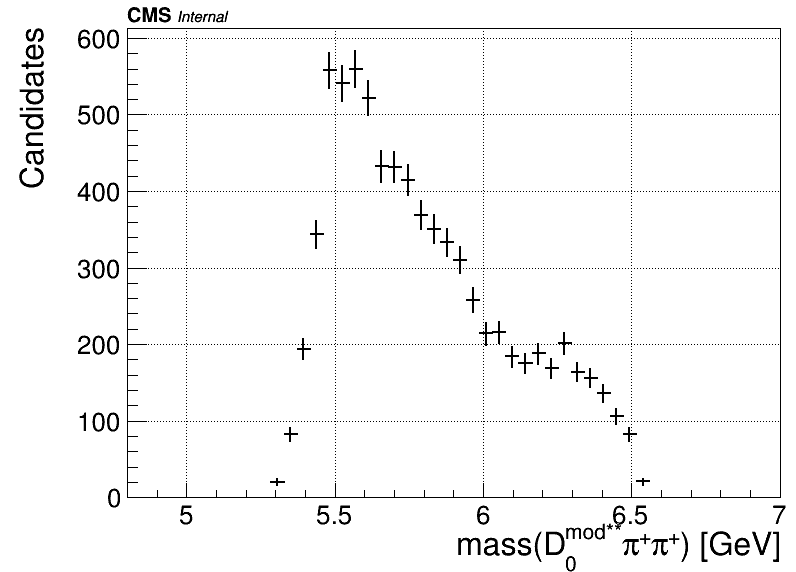

In [72]:
h = create_TH1D(dset['mass_D0pipi_scaledDstst'], name='h',
                title='', axis_title=['mass(D_{0}^{mod**}#pi^{+}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.8, 7] )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetGrid()

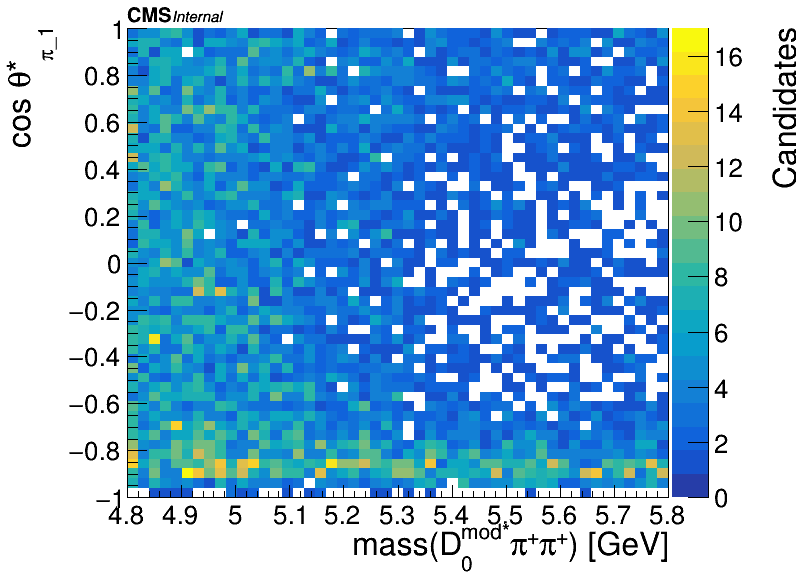

In [81]:
h = create_TH2D(np.column_stack((dset['mass_D0pipi_scaledDst'], dset['cosThetaSt_pi1'])), name='h',
                title='', axis_title=['mass(D_{0}^{mod*}#pi^{+}#pi^{+}) [GeV]', 'cos #theta*_{#pi_1}', 'Candidates'],
                binning=[np.linspace(4.8, 5.8, 50), np.linspace(-1, 1, 50)] )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

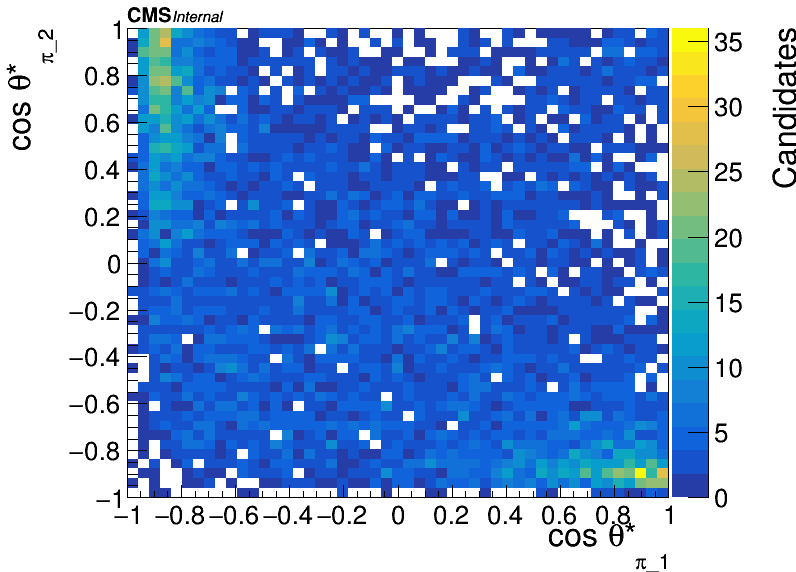

In [82]:
h = create_TH2D(np.column_stack((dset['cosThetaSt_pi1'], dset['cosThetaSt_pi2'])), name='h',
                title='', axis_title=['cos #theta*_{#pi_1}', 'cos #theta*_{#pi_2}', 'Candidates'],
                binning=[np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)] )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

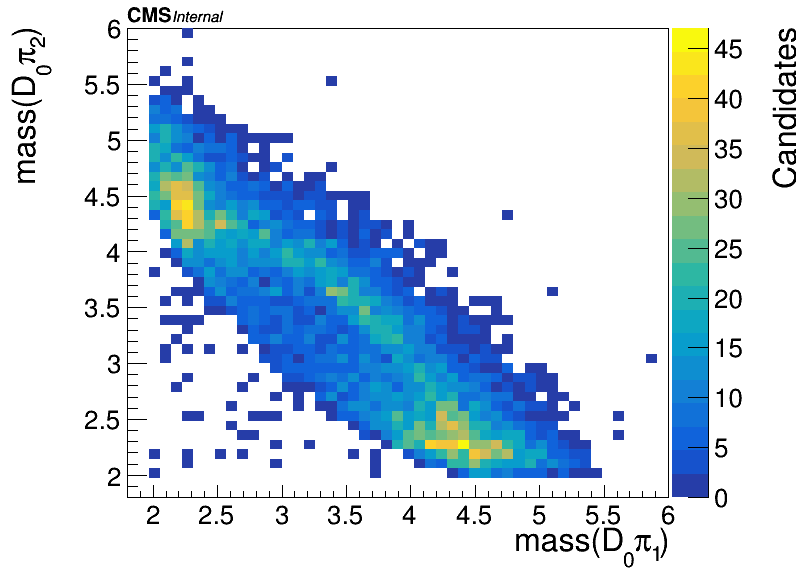

In [85]:
h = create_TH2D(np.column_stack((dset['mass_D0pi1'], dset['mass_D0pi2'])), name='h',
                title='', axis_title=['mass(D_{0}#pi_{1})', 'mass(D_{0}#pi_{2})', 'Candidates'],
                binning=[np.linspace(1.8, 6, 50), np.linspace(1.8, 6, 50)] )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

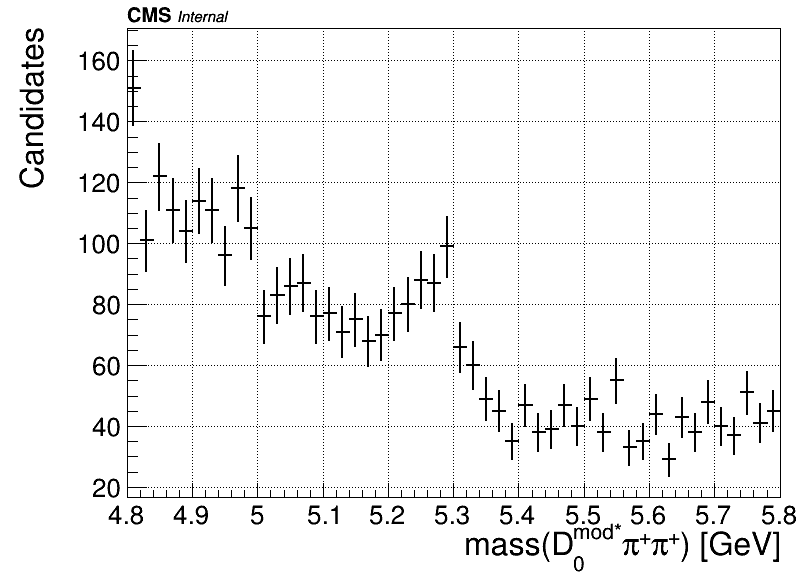

In [91]:
sel = np.logical_or(dset['mass_D0pi1']<2.5, dset['mass_D0pi2']<2.5)
h = create_TH1D(dset['mass_D0pipi_scaledDst'][sel], name='h',
                title='', axis_title=['mass(D_{0}^{mod*}#pi^{+}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.8, 5.8] )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetGrid()

Quanti di questi hanno il pione moscio dal D* ricostruito e selezionato?